# Binary Classification
This notebook contains the code to experiment with the embeddings created by a fine-tuned S-BERT model for **binary** classification. Includes loading data, loading the model, and running different models for the classification

In [ ]:
! pip install \
  scprep\
  spacy==2.3.2 \
  sentence_transformers==0.4.0 \
  phate==1.0.4 && \
  python -m spacy download es_core_news_lg

<span style="color:red"><strong>WARNING!</strong></span> Once you installed the packages in the previous cell you must restart your runtime and then import the library and load the model

In [1]:
import spacy
if spacy.prefer_gpu():
    print("Using the GPU")
else:
    print("Using the CPU")
es_nlp = spacy.load('es_core_news_lg')

Using the GPU


For development work, in case you want to update the files in your GitHub branch by rerunning the clone, you first have to empty the folder.

In [2]:
!rm -rf policy-data-analyzer/

In [3]:
# Define branch to clone
! branch_name='master' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 713, done.
remote: Counting objects: 100% (713/713), done.
remote: Compressing objects: 100% (538/538), done.
remote: Total 3633 (delta 343), reused 517 (delta 173), pack-reused 2920
Receiving objects: 100% (3633/3633), 168.42 MiB | 30.94 MiB/s, done.
Resolving deltas: 100% (1891/1891), done.
Checking out files: 100% (865/865), done.


In [4]:
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
import time
import cupy as cp
import json

os.chdir("policy-data-analyzer") #If you run this cell more than once, comment out this line because you are ready in this folder and you will get an error
from tasks.data_loading.src.utils import *
from tasks.model_evaluation.src.model_evaluator import *
from tasks.data_visualization.src.plotting import *
from tasks.data_augmentation.src.zero_shot_classification.latent_embeddings_classifier import *

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Run binary class classification experiments

### Data Loading

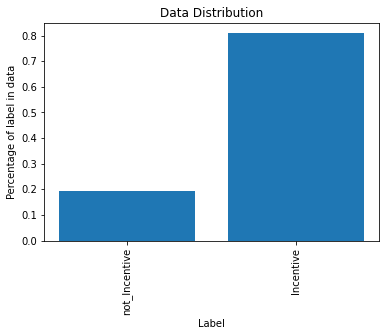

Label counts:
{'not_Incentive': 0.19183168316831684, 'Incentive': 0.8081683168316832}
Train Sentence: Será competencia del Órgano Ejecutivo en el Ramo de Hacienda, según sea el caso, ejercer la vigilancia y control del régimen fiscal de las actividades incentivadas.
 
Train Label: Incentive
Test Sentence: Los incentivos serán pagados por el Ministerio de Finanzas Públicas a las personas señaladas en el artículo 8 de esta Ley, contra la presentación del certificado emitido por el Instituto Nacional de Bosques –INAB-, que indique el cumplimiento del plan de manejo aprobado.
 
Test Label: Incentive


In [6]:
experiment = "EXP30"
classifier = "Binary"

# This first one is the one used by David and Daniel
base_path = "/content/drive/MyDrive/WRI-LatinAmerica-Talent"

# This one is the one used by Jordi
# base_path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/datasets/{classifier}/"
  
train_sents, train_labels, test_sents, test_labels = load_dataset(data_path, experiment)
label_names = unique_labels(train_labels)
numeric_train_labels = labels2numeric(train_labels, label_names)
plot_data_distribution(numeric_train_labels, label_names)
print("Train Sentence:", train_sents[2], "\nTrain Label:", train_labels[2])
print("Test Sentence:", test_sents[2], "\nTest Label:", test_labels[2])

### Load best model from training

In [7]:
model_name = "paraphrase-xlm-r-multilingual-v1"
test_perc = 0.25
num_epochs = 2
model_deets = f"model={model_name}_test-perc={test_perc}_n-epoch={num_epochs}"

saved_model_path = f"{base_path}/Modeling/{classifier}ClassificationExperiments/TESTS/{experiment}"

In [8]:
bin_model = SentenceTransformer(saved_model_path)

### Encode Sentences

First, we will check how good are the fine tuned embeddings without the projection matrix addition

In [9]:
all_sent_embs = encode_all_sents(test_sents, bin_model)

100%|██████████| 203/203 [00:03<00:00, 57.68it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 203 samples in 0.001s...
[t-SNE] Computed neighbors for 203 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 203 / 203
[t-SNE] Mean sigma: 1.657047
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.095413
[t-SNE] KL divergence after 1000 iterations: 0.254581


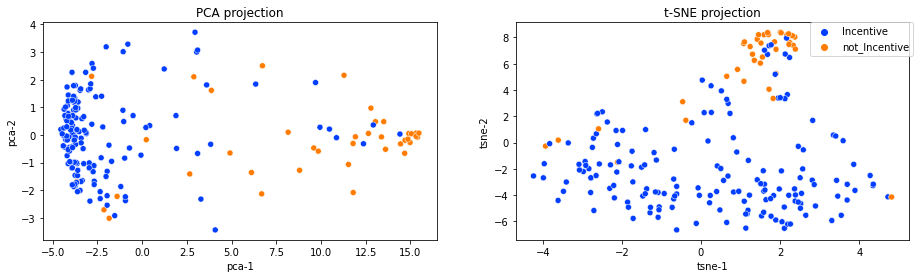

In [10]:
visualize_embeddings_2D(np.vstack(all_sent_embs), test_labels, tsne_perplexity=50)

Ok, doesn't look that bad, but not perfect either... The incentives are scattered too much in the space, and the line between non-incentives and incentives is not clearly defined. ***For now, it doesn't matter - but we should experiment more with fine tuning.***.

Now, let's check whether the projection matrix helps:

In [11]:
proj_matrix = cp.asnumpy(calc_proj_matrix(train_sents, 50, es_nlp, bin_model, 0.01))
all_sent_embs = encode_all_sents(test_sents, bin_model, proj_matrix)

100%|██████████| 203/203 [00:05<00:00, 35.50it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 203 samples in 0.000s...
[t-SNE] Computed neighbors for 203 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 203 / 203
[t-SNE] Mean sigma: 11.356366
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.398811
[t-SNE] KL divergence after 1000 iterations: 0.431297


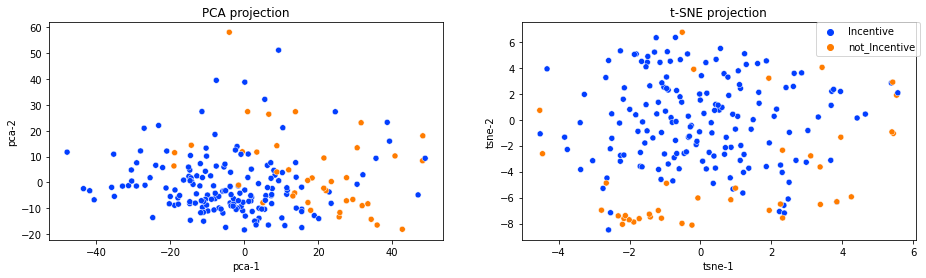

In [12]:
visualize_embeddings_2D(np.vstack(all_sent_embs), test_labels, tsne_perplexity=50)

Actually, the projection matrix makes things worse. ***Let's NOT use it for now!!!!!***

In [ ]:
# Simple embeddings, no projection matrix added
all_sent_embs = encode_all_sents(train_sents, bin_model)

100%|██████████| 1220/1220 [00:22<00:00, 54.73it/s]


In [ ]:
all_test_embs = encode_all_sents(test_sents, bin_model)

100%|██████████| 306/306 [00:05<00:00, 54.31it/s]


### Train classifiers

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

1. Let's start with Random Forests!

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=69420)

In [ ]:
clf.fit(np.vstack(all_sent_embs), all_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=69420,
                       verbose=0, warm_start=False)

In [ ]:
clf_preds = [clf.predict(sent_emb)[0] for sent_emb in all_test_embs]

In [ ]:
 print(classification_report(test_labels, clf_preds))

               precision    recall  f1-score   support

    Incentive       0.89      0.93      0.91       228
not_Incentive       0.76      0.68      0.72        78

     accuracy                           0.86       306
    macro avg       0.83      0.80      0.81       306
 weighted avg       0.86      0.86      0.86       306



In [ ]:
numeric_preds = labels2numeric(clf_preds, label_names)
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)

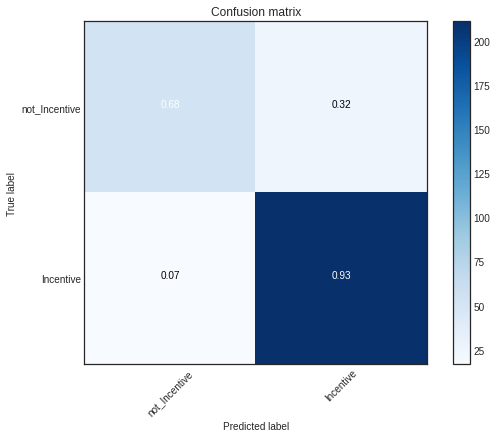

In [ ]:
evaluator.plot_confusion_matrix(color_map='Blues')

Honestly, without Grid Search and 5-fold Cross Validation, these are not bad results... We should add those though!

2. Now, we're gonna try Support Vector Machines

In [ ]:
from sklearn import svm

In [ ]:
clf = svm.SVC(gamma=0.001, C=100.)

In [ ]:
clf.fit(np.vstack(all_sent_embs), all_labels)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf_preds = [clf.predict(sent_emb)[0] for sent_emb in all_test_embs]

In [ ]:
numeric_preds = labels2numeric(clf_preds, label_names)
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)

In [ ]:
print(classification_report(test_labels, clf_preds))

               precision    recall  f1-score   support

    Incentive       0.91      0.92      0.92       228
not_Incentive       0.76      0.74      0.75        78

     accuracy                           0.88       306
    macro avg       0.84      0.83      0.84       306
 weighted avg       0.87      0.88      0.88       306



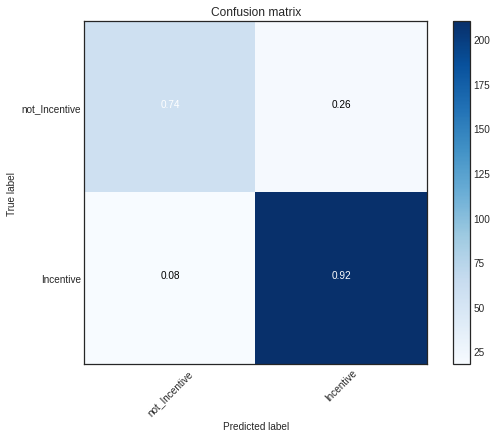

In [ ]:
evaluator.plot_confusion_matrix(color_map='Blues')

Ok, so SVMs are slightly better than Random Forests at ***differentiating*** text! There's a 1-2% decrease in performance for the incentive class, but a 6% gain in non-incentives. If these results remain when doing cross validation and grid search, then I'd recommend going for the SVMs.


**Next steps:**
- Add Grid Search Cross Validation from sklearn

### What about... Beto?
I downloaded the weights and placed them in the folder below: 

In [ ]:
!pip install transformers

In [ ]:
beto_path = f"{base_path}/Modeling/BETO/pytorch/"

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

***IMPORTANT:*** I was not able to figure out a way of using the fine tuning results from the models above so I'm gonna use BETO out of the box, for both encoding/classification and see how it goes.

The following cells are a demo of how the model should be put to use - once you understand it, feel free to skip this part!

In [ ]:
tokenizer = BertTokenizer.from_pretrained(beto_path)
model = BertForSequenceClassification.from_pretrained(beto_path)

Some weights of the model checkpoint at /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/BETO/pytorch/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificati

In [ ]:
classes = ["no es parafrasis", "es parafrasis"]

sequence_0 = "La compañia Hugging esta basada en Nueva York"
sequence_1 = "Las manzanas son malas para la salud"
sequence_2 = "La sede principal de Hugging esta en Manhattan"

paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")

paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits

paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]

In [ ]:
print(">>> Deberia de ser parafrasis:")
for i in range(len(classes)):
  print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")

print("\n>>> NO deberia de ser parafrasis:")
for i in range(len(classes)):
  print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

>>> Deberia de ser parafrasis:
no es parafrasis: 41%
es parafrasis: 59%

>>> NO deberia de ser parafrasis:
no es parafrasis: 61%
es parafrasis: 39%


OK! Now it's time to apply it to our data. We will try it out with our test set, just to have a fair comparison

In [ ]:
tokenized_sents = tokenizer(test_sents, padding=True, return_tensors="pt")
clf_logits = model(**tokenized_sents).logits
clf_results = torch.softmax(clf_logits, dim=1).tolist()[0]

In [ ]:
# This stores the index of the highest score - in other words, our label
clf_preds = [np.argmax(logits) for logits in clf_results]

In [ ]:
print(classification_report(test_labels, clf_preds))

In [ ]:
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=clf_preds)
evaluator.plot_confusion_matrix(color_map='Blues')

1